In [1]:
import invisible_cities.io.dst_io as dio


import numpy as np
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.spatial import Delaunay

from sklearn.neighbors import BallTree

import torch

import sys
sys.path.append('/home/usc/ie/mpm/data_labelling/')
sys.path.append('/home/usc/ie/mpm/NEXT_graphs/')

from labelling.MClabelling import labelling_MC
from utils.plotting_utils import plot_3d_hits
import pandas as pd

In [2]:
i = 3

file_label = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/13bar/0nubb/label/prod/nexus_label_{n}_0nubb.h5'
df = dio.load_dst(file_label.format(n=i), 'DATASET', 'MCVoxels')

file_nexus = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/13bar/0nubb/nexus/nexus_{n}_0nubb.h5'
df_nexus = dio.load_dst(file_nexus.format(n=i), 'MC', 'hits')


In [3]:
dat_id = 0
coords = ['x', 'y', 'z']
df_ev = df[df.dataset_id == dat_id]
df_nexus.event_id = df_nexus.event_id - df_nexus.event_id.unique()[0]
df_nexus_ev = df_nexus[df_nexus.event_id == dat_id]


# voxels = [tuple(x) for x in df_ev[coords].to_numpy()]

In [4]:
def plot_graph_ener(track_graph, pos, nodes, label, cmap = plt.cm.cool, nsize = 200, with_labels = True, title = ''):
    nx.draw(track_graph, pos, node_color=list(nodes), cmap=cmap, node_size=nsize, with_labels=with_labels)

    blob_nodes = [i for i, n in enumerate(label) if n == 3]
    nx.draw_networkx_nodes(track_graph, pos, nodelist=blob_nodes, node_color='none', edgecolors='black', node_size=nsize, linewidths=1.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(list(nodes)), vmax=max(list(nodes))))
    sm.set_array([])  # An empty array is required for ScalarMappable
    # Generate a legend with the marker and label
    legend_marker = plt.Line2D([], [], marker='o', color='white', markersize=10, markeredgewidth=1, markeredgecolor='black', label='Blob label')
    # Add the legend to the plot
    plt.legend(handles=[legend_marker])
    # Add a colorbar
    plt.colorbar(sm, label='Energy')
    plt.title(title)
    plt.show()

In [5]:
def create_graph(df, max_distance, coords):
    '''
    Takes a dataframe and creates a graph with the coordinates as nodes, which are connected by edges 
    if they are separated less than certain distance.
    
    Args:
        df: DATAFRAME
    Contains spatial information (at least).
        
        max_distance: FLOAT
    Indicates the maximum distance between nodes to be connected.
        
        coords: LIST OF STR
    Indicates the names of the df columns that have the coordinates info.
    
    RETURNS: 
        graph: NETWORKX GRAPH
    Graph with the nodes and their connections.
    '''
    
    voxels = [tuple(x) for x in df[coords].to_numpy()]
    
    graph = nx.Graph()
    for i, voxel in enumerate(voxels):
        graph.add_node(i, pos=voxel)
    #Ahora hacemos los edges para contar las componentes conexas
    for va, vb in itertools.combinations(graph.nodes(), 2):
        va_arr, vb_arr = np.array(graph.nodes[va]['pos']), np.array(graph.nodes[vb]['pos'])
        dis = np.linalg.norm(va_arr-vb_arr)
        if dis <= max_distance:
            graph.add_edge(va, vb, distance = dis)
    return graph



In [6]:
def create_graph_nneigh(df, N, coords = ['x', 'y', 'z']):
    voxels = [tuple(x) for x in df[coords].to_numpy()]
    # Build the KD-Tree for efficient neighbor search
    tree = KDTree(voxels)

    # Initialize the graph
    G = nx.Graph()

    # Add nodes to the graph
    for i, voxel in enumerate(voxels):
        G.add_node(i, pos=voxel)

    # Find the N nearest neighbors for each voxel and add edges
    for i, voxel in enumerate(voxels):
        # Query the KD-Tree for the N+1 nearest neighbors (first one is the voxel itself)
        distances, indices = tree.query(voxel, k=N+1)
        
        # Add edges to the graph for the nearest neighbors
        for neighbor_index, distance in zip(indices[1:], distances[1:]):  # Skip the first one (it's the voxel itself)
            G.add_edge(i, neighbor_index, weight=distance)
    return G


In [7]:
def create_graph_delaunay(df, coords = ['x', 'y', 'z']):
    # List of voxel positions as (x, y, z) tuples
    voxels = [tuple(x) for x in df[coords].to_numpy()]

    # Compute Delaunay triangulation
    tri = Delaunay(voxels)

    # Initialize the graph
    G = nx.Graph()

    # Add nodes to the graph
    for i, voxel in enumerate(voxels):
        G.add_node(i, pos=voxel)

    # Add edges based on Delaunay tetrahedrons
    for simplex in tri.simplices:
        # Each simplex is a tetrahedron (list of four indices)
        for i in range(len(simplex)):
            for j in range(i + 1, len(simplex)):
                # Add edge between each pair of points in the tetrahedron
                p1, p2 = simplex[i], simplex[j]
                # Calculate the Euclidean distance
                dist = np.linalg.norm(np.array(voxels[p1]) - np.array(voxels[p2]))
                # Add edge with distance as the weight
                G.add_edge(p1, p2, weight=dist)
    return G
    # Now G is your graph with nodes and edges based on Delaunay triangulation

In [8]:
G_classic = create_graph(df_ev, np.sqrt(3), ['x', 'y', 'z'])
G_nneigh = create_graph_nneigh(df_ev, 6)
G_delaunay = create_graph_delaunay(df_ev)

In [9]:
import matplotlib as mpl
import pandas as pd
def plot_3d_hits(hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet, opacity = 1):
    '''
    Function to plot hits

    Args:
        hits: DataFrame or list/tuple/array of lists/tuples/arrays
    Contains the spatial information of the hits and their content. If we don't use a DataFrame, the input
    must have the structure (x, y, z, content), where content is usually the energy or the segclass. Its shape
    will be (4, N).

        value: STR
    Name of the content column in the DataFrame. Will be also the label of the colorbar.

        coords: LIST
    Name of the coords column in the DataFrame.

        cmap: matplotlib.cm
    Used colormap.

        opacity = FLOAT
    Value from 0 to 1 that indicates the opacity of the hits.
    '''

    if type(hits) == type(pd.DataFrame()):
        pass
    else:
        coor = np.array(hits).T
        hits = pd.DataFrame(coor, columns = coords + [value])

    xcoord  = hits[coords[0]].values
    ycoord  = hits[coords[1]].values
    zcoord  = hits[coords[2]].values
    content = hits[value].values

    fig  = plt.figure(figsize=(8, 8), frameon=False)
    gs   = fig.add_gridspec(12, 12)
    ax   = fig.add_subplot(gs[0:12, 0:10], projection = '3d')
    axcb = fig.add_subplot(gs[1:11, 11])
    norm = mpl.colors.Normalize(vmin=min(content), vmax=max(content))

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(content))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(xcoord, ycoord, zcoord, c=colors * opacity, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')


    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    # ax.view_init(elev = 0, azim = 90) # for (z, x)
    ax.view_init(elev = 90, azim = 0) # for (x, y)
    # ax.view_init(elev = 180, azim = 0) # for  (z, y)

    cb.set_label (value, size = 15)
    cb.ax.tick_params(labelsize=13)
    cb.formatter.set_powerlimits((0, 0))
    plt.show()

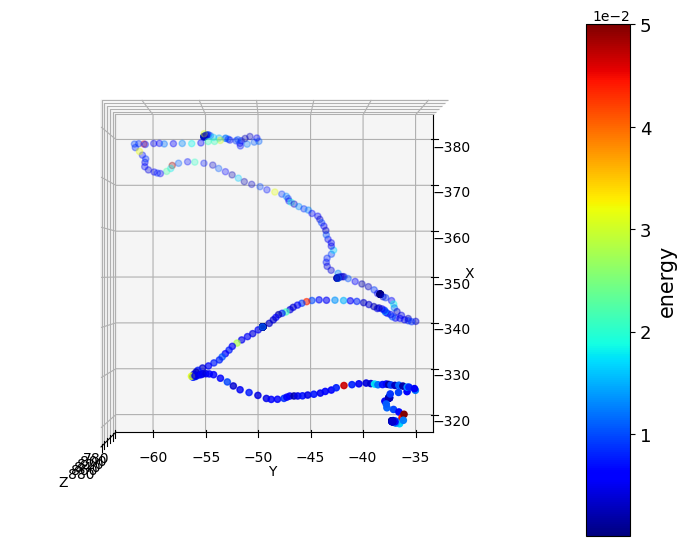

In [10]:
plot_3d_hits(df_nexus_ev, 'energy')

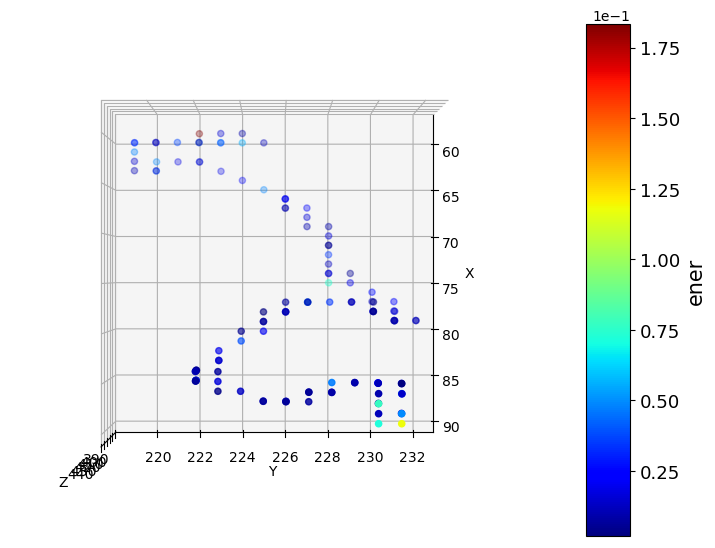

In [11]:
plot_3d_hits(df_ev, 'ener')

In [12]:
len(G_classic.edges) * 2, len(G_nneigh.edges) * 2, len(G_delaunay.edges) * 2 # times 2 because im doing non directed graphs

(466, 804, 1598)

In [13]:
df_ev[['x', 'y']].values[0][0]

59

In [14]:
cosa = np.array([np.array([v[0], v[1] + z[0]]) for v, z in zip(df_ev[['x', 'y']].values, df_ev[['z']].values)])

In [15]:
df_ev

,x,y,z,ener,ratio,segclass,nhits,binclass,ext,dataset_id,elem_ener,elem,elem_count,cloud_ener,cloud,cloud_count,nblob,blob_success
0,59,222,392,0.183243,1.000000,3,21,1,1,0,0.460125,3_0,2.0,2.45783,c_0,1.0,2,True
1,59,223,393,0.014899,1.000000,3,1,1,0,0,0.460125,3_0,2.0,2.45783,c_0,1.0,2,True
2,59,224,393,0.008553,1.000000,3,2,1,0,0,0.460125,3_0,2.0,2.45783,c_0,1.0,2,True
3,60,219,393,0.045390,1.000000,2,1,1,0,0,1.774141,2_0,1.0,2.45783,c_0,1.0,2,True
4,60,219,394,0.025354,0.706904,2,3,1,0,0,1.774141,2_0,1.0,2.45783,c_0,1.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,88,230,437,0.011151,1.000000,2,1,1,0,0,1.774141,2_0,1.0,2.45783,c_0,1.0,2,True
119,88,231,436,0.016081,1.000000,2,2,1,0,0,1.774141,2_0,1.0,2.45783,c_0,1.0,2,True
120,88,231,437,0.050003,1.000000,2,1,1,0,0,1.774141,2_0,1.0,2.45783,c_0,1.0,2,True
121,89,230,437,0.071963,1.000000,3,19,1,2,0,0.071963,3_1,2.0,2.45783,c_0,1.0,2,True


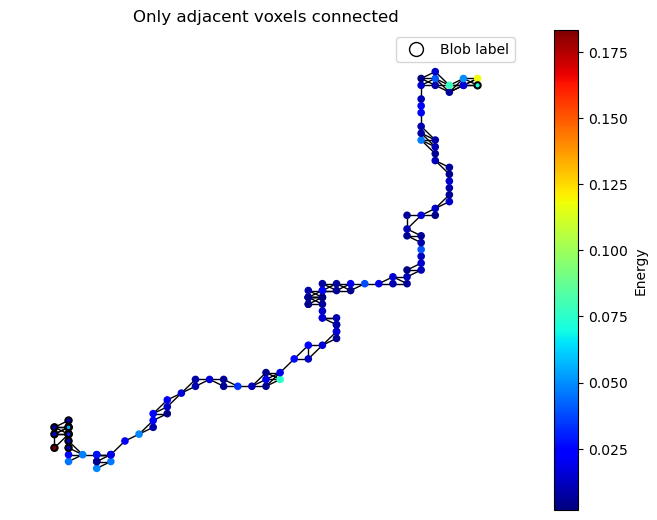

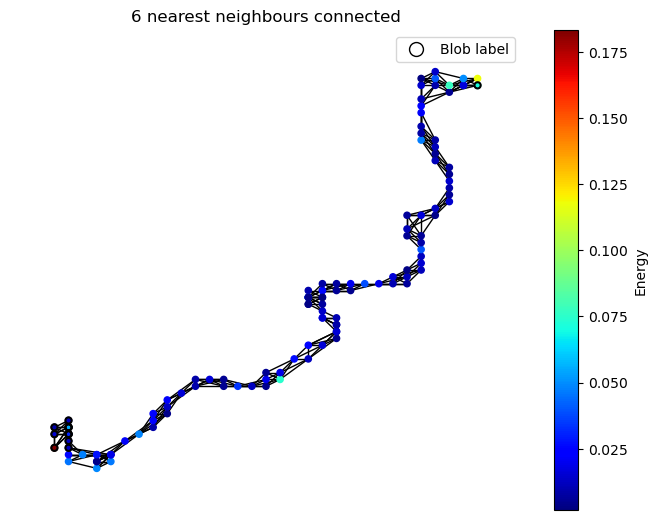

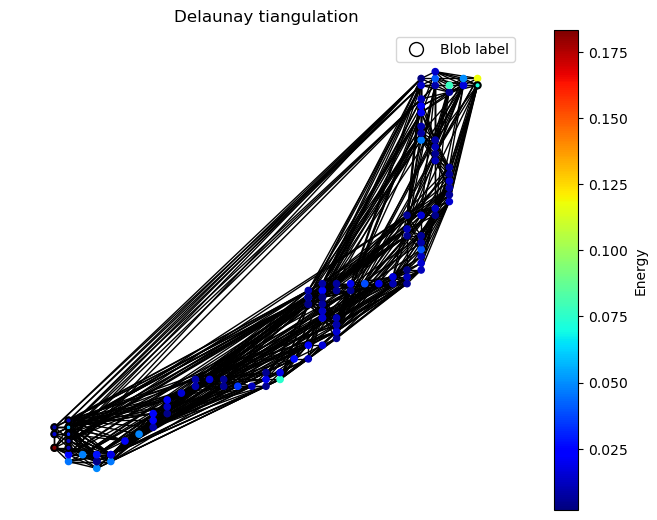

In [16]:
plot_graph_ener(G_classic, cosa, df_ev.ener.values, df_ev.segclass.values, nsize=20,cmap = plt.cm.jet, with_labels=False, title = 'Only adjacent voxels connected')
plot_graph_ener(G_nneigh, cosa, df_ev.ener.values, df_ev.segclass.values, nsize=20, cmap = plt.cm.jet, with_labels=False, title = '6 nearest neighbours connected')
plot_graph_ener(G_delaunay, cosa, df_ev.ener.values, df_ev.segclass.values, nsize=20, cmap = plt.cm.jet, with_labels=False, title = 'Delaunay tiangulation')

Here i have developed the function that works exactly the same but with Nearest Neighbor (which is aready implemented in the code as `edge_index`)

In [51]:
def graph_near(event, 
               num_neigh, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coords = ['xbin', 'ybin', 'zbin'], 
               ener_name = 'ener'):
    ''' 
    The function uses KDTree algorithm to create edge tensors for the graphs.
    Edges can be created based on N nearest neighbours, using the classic 
    approach or connecting all of them.
    Classic approach is achieved fixing max_dist = sqrt(3) and num_neigh = 26.
    To connect all, num_neigh = len(event) - 1 (to search for all the neighbors).

    Creates the edge index tensor, with shape [2, E] where E is the number of edges.
    It contains the index of the nodes that are connected by an edge. 
    Also creates the edge features tensor, with shape [E, D] being D the number of features. In this case we add the distance, and a sort of gradient.
    Also creates the edge weights tensor, with shape E: one weight assigned to each edge. In this case we use the inverse of the distance. 
    '''
    # Functions for edge features
    def grad(ener, dis, i, j): return abs(ener[i] - ener[j]) / dis
    def inve(dis): return 1 / dis

    # Fix values for different edge creations
    max_dist = np.inf
    if classic:
        num_neigh = 26
        max_dist = np.sqrt(3)
    if all_connected:
        num_neigh = len(event) - 1


    voxels = [tuple(x) for x in event[coords].to_numpy()]
    ener  = event[ener_name].values
    ener = ener / sum(ener) if norm_features else ener
    edges, edge_features, edge_weights = [], [], []
    
    # Build the KD-Tree 
    tree = KDTree(voxels)
    # List to append the nodes we already looked into (to create direct graphs)
    passed_nodes = []
    for i, voxel in enumerate(voxels):
        # For each voxel, get the N+1 neares neighbors (first one is the voxel itself)
        distances, indices = tree.query(voxel, k=num_neigh+1)
        # For each neighbor, add edges
        for j, dis in zip(indices[1:], distances[1:]):  # Skip the first one (it's the voxel itself)
            # Skip already passed nodes to create directed graphs
            if directed and np.isin(passed_nodes, j).any(): continue 
            # Condition for classical / all connected aproaches
            if all_connected or dis <= max_dist:
                edges.append([i, j])
                edge_features.append([dis, grad(ener, dis, i, j)])
                edge_weights.append(inve(dis))
        passed_nodes.append(i)
    # Transform into the required tensors
    edges, edge_features, edge_weights = torch.tensor(edges, dtype = torch.long).T, torch.tensor(edge_features), torch.tensor(edge_weights)
    return edges, edge_features, edge_weights


In [52]:
dat_id = 111
nneigh = 6
df_ev = df[df.dataset_id == dat_id]
G = graph_near(df_ev, nneigh, directed = False, classic = False, all_connected=False, coords = coords)
print('New method: ', G[0].shape)
G = graph_near(df_ev, nneigh, directed = False, classic = True, all_connected=False, coords = coords)
print('Classic method undirected: ', G[0].shape)
G = graph_near(df_ev, nneigh, directed = True, classic = True, all_connected=False, coords = coords)
print('Classic method directed: ', G[0].shape)
G = graph_near(df_ev, nneigh, directed = False, classic = True, all_connected=True, coords = coords)
print('Classic method undirected all_connected: ', G[0].shape)
G = graph_near(df_ev, nneigh, directed = True, classic = True, all_connected=True, coords = coords)
print('Classic method directed all_connected: ', G[0].shape)

New method:  torch.Size([2, 786])
Classic method undirected:  torch.Size([2, 644])
Classic method directed:  torch.Size([2, 322])
Classic method undirected all_connected:  torch.Size([2, 17030])
Classic method directed all_connected:  torch.Size([2, 8515])


In [53]:
dat_id = 124
nneigh = 6
df_ev = df[df.dataset_id == dat_id].reset_index(drop = True)
G = graph_near(df_ev, nneigh, directed = False, classic = False, all_connected=False, coords = coords)
print('New method: ', G[0].shape)
# G = graph_near(df_ev, nneigh, directed = False, classic = True, all_connected=False, coords = coords)
# print('Classic method undirected: ', G[0].shape)
# G = graph_near(df_ev, nneigh, directed = True, classic = True, all_connected=False, coords = coords)
# print('Classic method directed: ', G[0].shape)
# G = graph_near(df_ev, nneigh, directed = False, classic = True, all_connected=True, coords = coords)
# print('Classic method undirected all_connected: ', G[0].shape)
# G = graph_near(df_ev, nneigh, directed = True, classic = True, all_connected=True, coords = coords)
# print('Classic method directed all_connected: ', G[0].shape)

New method:  torch.Size([2, 726])


### Check this works for any kind of data

Voy a probar a ver que tal funcionan directamente las funciones con ficheros de sensim; en principio deberían ir bien, veamos

Parece que van pepino asi que guay

In [10]:
sys.path.append('/home/usc/ie/mpm/NEXT_graphs/')

from NEXT_graphNN.utils.data_loader import graphData

In [11]:
p = '5bar'
dt = '0nubb'
prod = 'sensim_15mm'
n = 1

sensim_file = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/{p}/{dt}/prod/{prod}/sensim_{n}_{dt}.h5'.format(p = p, dt=dt, prod=prod, n = n)

In [12]:
group = 'Sensim'
table = 'sns_df'
dat_id = 0

In [13]:
df = dio.load_dst(sensim_file, group, table)
get_fnum_function = lambda filename: int(filename.split("/")[-1].split("_")[-2])
fnum = get_fnum_function(sensim_file)
ev = df[df.event == dat_id]

In [14]:
ev

,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass
0,0,-195.0,-345.0,537.60,0.000490,4,1,1
1,0,-150.0,-345.0,537.60,0.000490,4,1,3
2,0,-135.0,-345.0,554.40,0.000490,4,1,3
3,0,-135.0,-345.0,557.55,0.000613,5,1,3
4,0,-135.0,-345.0,558.60,0.000490,4,1,3
...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1


In [30]:
num_neigh = 6
feature_n = ['energy']
label_n = 'segclass'
norm_features = True
classic = False
directed = False
all_connected = False
coord_names = ['x_sipm', 'y_sipm', 'z_slice']
simplify_segclass = False
torch_dtype = torch.float

In [31]:
event = ev.reset_index(drop = True)
graph_data = graphData(event, 
                        dat_id, 
                        num_neigh,
                        feature_n=feature_n, 
                        label_n=label_n, 
                        norm_features = norm_features, 
                        directed=directed,
                        classic=classic,
                        all_connected=all_connected,
                        coord_names=coord_names, 
                        simplify_segclass = simplify_segclass, 
                        torch_dtype = torch_dtype)

In [32]:
ev

,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass
0,0,-195.0,-345.0,537.60,0.000490,4,1,1
1,0,-150.0,-345.0,537.60,0.000490,4,1,3
2,0,-135.0,-345.0,554.40,0.000490,4,1,3
3,0,-135.0,-345.0,557.55,0.000613,5,1,3
4,0,-135.0,-345.0,558.60,0.000490,4,1,3
...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1


In [33]:
graph_data

Data(x=[2086, 1], edge_index=[2, 12516], edge_attr=[12516, 2], y=[2086], edge_weight=[12516], num_nodes=2086, coords=[2086, 3], dataset_id=0, binclass=1)

## Pienso que me estaba construyendo mal los grafos, voy a comprobarlo...

In [15]:
data_mc = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/label/prod/nexus_label_1_0nubb.h5'
data_sns = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/prod/sensim_15mm/sensim_1_0nubb.h5'

graph_mc = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/graph_nn/nneigh_prod/prod/nexus_graph_nn_1_0nubb.pt.gz'
graph_sns = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/graph_nn/sensim_15mm_prod/prod/sensim_graph_nn_1_0nubb.pt.gz'
new_graph_sns = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/graph_nn/sensim_15mm_zrebin_prod/prod/sensim_graph_nn_1_0nubb.pt.gz'

In [16]:
from invisible_cities.io.dst_io import load_dst

mc_df = load_dst(data_mc, 'DATASET','MCVoxels')
mc_ev = mc_df[mc_df.dataset_id == 0]

sns_df = load_dst(data_sns, 'Sensim', 'sns_df')
sns_ev = sns_df[sns_df.event == 0]

In [17]:
import gzip
def load_graph_data_compressed(fname):
    dataset = []
    if isinstance(fname, list):
        for path in fname:
            print(path)
            with gzip.open(path, 'rb') as f:
                dataset.extend(torch.load(f))
    if isinstance(fname, str):
        with gzip.open(fname, 'rb') as f:
            dataset.extend(torch.load(f))
    return dataset

In [18]:
mc_ev_graph = load_graph_data_compressed(graph_mc)[0]
sns_ev_graph = load_graph_data_compressed(graph_sns)[0]
new_sns_ev_graph = load_graph_data_compressed(new_graph_sns)[0]

In [46]:
graph_mc = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/graph_nn/nneigh_prod/prod/nexus_graph_nn_{i}_0nubb.pt.gz'
new_graph_sns = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/0nubb/graph_nn/sensim_15mm_zrebin_prod/prod/sensim_graph_nn_{i}_0nubb.pt.gz'

nnodes_mc, nnodes_sns = [], []
for i in range(1, 21):
    print(i)
    mc_graphs = load_graph_data_compressed(graph_mc.format(i = i))
    sns_graphs = load_graph_data_compressed(new_graph_sns.format(i = i))
    for mc_g in mc_graphs:
        nnodes_mc.append(mc_g.num_nodes)
    for sns_g in sns_graphs:
        nnodes_sns.append(sns_g.num_nodes)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


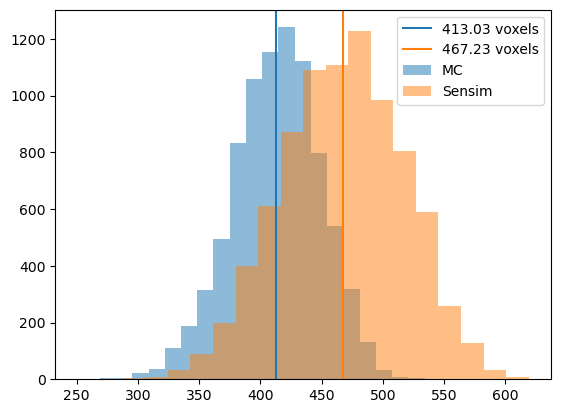

In [49]:
plt.hist(nnodes_mc, 20, alpha = 0.5, label = 'MC')
plt.axvline(np.mean(nnodes_mc), color = 'tab:blue', label = '{} voxels'.format(round(np.mean(nnodes_mc), 2)))
plt.hist(nnodes_sns, 20, alpha = 0.5, label = 'Sensim')
plt.axvline(np.mean(nnodes_sns), color = 'tab:orange', label = '{} voxels'.format(round(np.mean(nnodes_sns), 2)))
plt.legend()

In [51]:
6* np.mean(nnodes_sns) / np.mean(nnodes_mc)

6.78727444913222

In [52]:
7 / 6

1.1666666666666667

Tenemos el numero de nodos N, luego el número de conexiones E. Por ahora, tal y como construimos el grafo, el numero de conexiones va a ser E = nneigh * N

NO queremos que sea así, queremos que cada nodo tenga nneigh conexiones, pero al mismo tiempo que esas conexiones sean dobles para que el grafo sea undirected

In [23]:
mc_ev

,x,y,z,ener,ratio,segclass,nhits,binclass,dataset_id,elem_ener,elem,elem_count,cloud_ener,cloud,cloud_count,nblob,blob_success
0,125,125,150,0.002346,1.000000,2,1,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
1,125,126,149,0.008086,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
2,125,126,150,0.015565,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
3,125,127,148,0.012038,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
4,125,128,146,0.069976,0.931565,3,23,1,0,0.069976,3_1,2.0,2.436707,c_0,2.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,189,136,204,0.020437,1.000000,1,7,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
392,189,136,205,0.023155,1.000000,1,5,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
393,189,137,204,0.007149,1.000000,1,1,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
394,189,137,205,0.061076,1.000000,1,15,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True


In [24]:
mc_ev_graph

Data(x=[396, 4], edge_index=[2, 2376], edge_attr=[2376, 2], y=[396, 1], edge_weight=[2376], num_nodes=396, coords=[396, 3], dataset_id=0, binclass=1, fnum=1)

In [25]:
mc_ev_graph.num_edges / mc_ev_graph.num_nodes

6.0

Si convertimos nuestro grafo de PyG ACTUAL a un grafo de networkx veremos que el número de conexiones es menor: eso pasa porque en networkx cuando conectas por ambos lados nodos, sólo aparecen una vez. 

Entonces, E_networkx < E_PyG

La diferencia entre E_PyG - E_networkx es el numero de edges que aparece dos veces ya, lo llamo E_correct

De E_correct, si se lo resto a E_networkx - E_correct = E_miss --> los que me faltan!!

ENTONCES, si arreglo mi función, lo que debería obtener sería (E_correct + E_miss)  * 2, QUE ES LITERALMENTE 2 * E_nx

In [127]:
import networkx as nx
import numpy as np

# Initialize the graph
G = nx.Graph()

# Add nodes with their features
for i, feature in enumerate(mc_ev_graph.x):
    G.add_node(i, feature=feature[0])  # Assuming each feature is a scalar

# Add edges
for edge in mc_ev_graph.edge_index.T:
    G.add_edge(edge[0].item(), edge[1].item())

# G is now a NetworkX graph with node features and edges

In [128]:
# Initialize the graph
snsG = nx.Graph()

# Add nodes with their features
for i, feature in enumerate(sns_ev_graph.x):
    snsG.add_node(i, feature=feature[0])  # Assuming each feature is a scalar

# Add edges
for edge in sns_ev_graph.edge_index.T:
    snsG.add_edge(edge[0].item(), edge[1].item())

# G is now a NetworkX graph with node features and edges

In [140]:
# Initialize the graph
new_snsG = nx.Graph()

# Add nodes with their features
for i, feature in enumerate(new_sns_ev_graph.x):
    new_snsG.add_node(i, feature=feature[0])  # Assuming each feature is a scalar

# Add edges
for edge in new_sns_ev_graph.edge_index.T:
    new_snsG.add_edge(edge[0].item(), edge[1].item())

# G is now a NetworkX graph with node features and edges

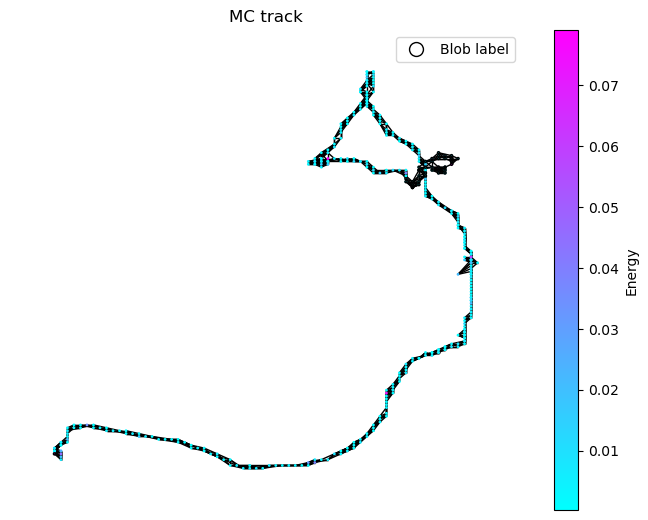

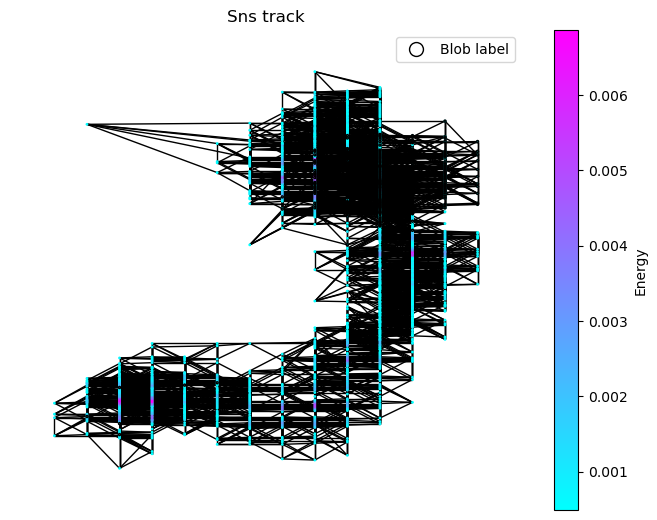

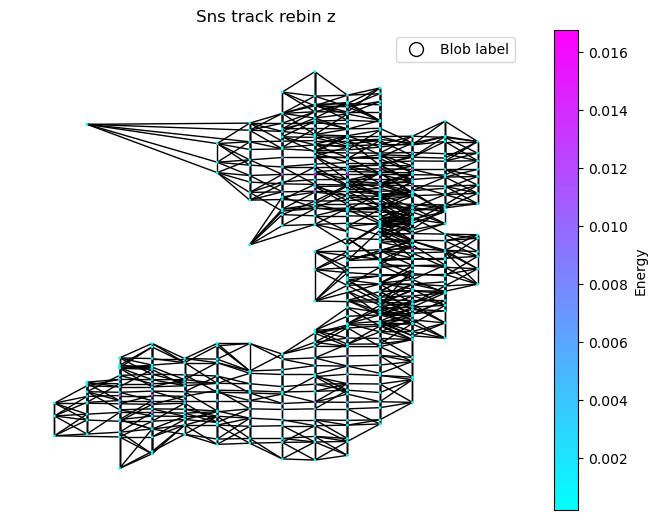

In [214]:
coord_pos = np.array([np.array([v[0], v[1] + z[0]]) for v, z in zip(mc_ev[['x', 'y']].values, mc_ev[['z']].values)])

plot_graph_ener(G, coord_pos, mc_ev.ener.values, mc_ev.segclass.values, nsize=1,cmap = plt.cm.cool, with_labels=False, title = 'MC track')

coord_pos = np.array([np.array([v[0], v[1] + z[0]]) for v, z in zip(sns_ev[['x_sipm', 'y_sipm']].values, sns_ev[['z_slice']].values)])

plot_graph_ener(snsG, coord_pos, sns_ev.energy.values, sns_ev.segclass.values, nsize=1,cmap = plt.cm.cool, with_labels=False, title = 'Sns track')


coord_pos = np.array([np.array([v[0], v[1] + z]) for v, z in zip(np.array(new_sns_ev_graph.coords[:, :2]), np.array(new_sns_ev_graph.coords[:, 2]))])

plot_graph_ener(new_snsG, coord_pos, np.array(new_sns_ev_graph.x.T)[0], np.array(new_sns_ev_graph.y.T)[0], nsize=1,cmap = plt.cm.cool, with_labels=False, title = 'Sns track rebin z')

In [112]:
def voxelize_sns(event, coord_names, new_coord_names, rebin_z = True):
    for coord, newcoord in zip(coord_names, new_coord_names):
        binsize = np.diff(sorted(event[coord].unique())).min()
        # make z bins 10x bigger
        if (coord == 'z_slice') & rebin_z:
            binsize = binsize * 10
        min_ = event[coord].min()
        max_ = event[coord].max()
        bins = np.arange(min_ - binsize / 2, max_ + binsize + binsize / 2, binsize)
        event[newcoord] = pd.cut(event[coord], bins = bins, labels = False)
    if rebin_z:
        event = event.groupby(['event', 'xbin', 'ybin', 'zbin']).agg({'energy':'sum', 
                                                                    'pes':'sum', 
                                                                    'x_sipm':'mean', 'y_sipm':'mean', 'z_slice':'mean', 
                                                                    'binclass':'max', 'segclass':'max'}).reset_index()
    return event

In [113]:
np.diff(sorted(sns_ev['z_slice'].unique())).min()

1.0499999999999545

In [114]:
cosa = voxelize_sns(sns_ev, ['x_sipm', 'y_sipm', 'z_slice'], ['xbin', 'ybin', 'zbin'])

/scratch/9156518/ipykernel_453007/1534601857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event[newcoord] = pd.cut(event[coord], bins = bins, labels = False)


In [119]:
cosa

,event,xbin,ybin,zbin,energy,pes,x_sipm,y_sipm,z_slice,binclass,segclass
0,0,0,5,0,0.000613,5,-285.0,-270.0,292.9500,1,2
1,0,0,6,1,0.001348,11,-285.0,-255.0,295.5750,1,2
2,0,0,7,0,0.000613,5,-285.0,-240.0,291.9000,1,2
3,0,1,5,1,0.001225,10,-270.0,-270.0,294.5250,1,2
4,0,1,6,0,0.003309,27,-270.0,-255.0,291.9000,1,2
...,...,...,...,...,...,...,...,...,...,...,...
510,0,13,7,12,0.002083,17,-90.0,-240.0,411.3375,1,1
511,0,13,8,11,0.000735,6,-90.0,-225.0,407.4000,1,1
512,0,13,8,12,0.002083,17,-90.0,-225.0,411.6000,1,1
513,0,13,9,11,0.000490,4,-90.0,-210.0,408.4500,1,1


In [120]:
voxelize_sns(sns_ev, ['x_sipm', 'y_sipm', 'z_slice'], ['xbin', 'ybin', 'zbin'], rebin_z = False)

/scratch/9156518/ipykernel_453007/1534601857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event[newcoord] = pd.cut(event[coord], bins = bins, labels = False)


,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass,xbin,ybin,zbin
0,0,-195.0,-345.0,537.60,0.000490,4,1,1,6,0,237
1,0,-150.0,-345.0,537.60,0.000490,4,1,3,9,0,237
2,0,-135.0,-345.0,554.40,0.000490,4,1,3,10,0,253
3,0,-135.0,-345.0,557.55,0.000613,5,1,3,10,0,256
4,0,-135.0,-345.0,558.60,0.000490,4,1,3,10,0,257
...,...,...,...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2,11,10,94
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1,11,10,114
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1,11,10,116
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1,11,10,117


In [66]:
cosa

,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass,xbin,ybin,zbin
0,0,-195.0,-345.0,537.60,0.000490,4,1,1,6,0,24
1,0,-150.0,-345.0,537.60,0.000490,4,1,3,9,0,24
2,0,-135.0,-345.0,554.40,0.000490,4,1,3,10,0,25
3,0,-135.0,-345.0,557.55,0.000613,5,1,3,10,0,26
4,0,-135.0,-345.0,558.60,0.000490,4,1,3,10,0,26
...,...,...,...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2,11,10,9
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1,11,10,11
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1,11,10,12
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1,11,10,12


In [71]:
cosa[(cosa.xbin == 0) & (cosa.ybin == 6) & (cosa.zbin == 1)]

,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass,xbin,ybin,zbin
748,0,-285.0,-255.0,294.00,0.000858,7,1,2,0,6,1
749,0,-285.0,-255.0,297.15,0.000490,4,1,2,0,6,1


In [87]:
cosa.groupby(['event', 'xbin', 'ybin', 'zbin']).agg({'energy':'sum', 'pes':'sum', 'x_sipm':'mean', 'y_sipm':'mean', 'z_slice':'mean', 'binclass':'max', 'segclass':'max'}).reset_index()

,event,xbin,ybin,zbin,energy,pes,x_sipm,y_sipm,z_slice,binclass,segclass
0,0,0,5,0,0.000613,5,-285.0,-270.0,292.9500,1,2
1,0,0,6,1,0.001348,11,-285.0,-255.0,295.5750,1,2
2,0,0,7,0,0.000613,5,-285.0,-240.0,291.9000,1,2
3,0,1,5,1,0.001225,10,-270.0,-270.0,294.5250,1,2
4,0,1,6,0,0.003309,27,-270.0,-255.0,291.9000,1,2
...,...,...,...,...,...,...,...,...,...,...,...
510,0,13,7,12,0.002083,17,-90.0,-240.0,411.3375,1,1
511,0,13,8,11,0.000735,6,-90.0,-225.0,407.4000,1,1
512,0,13,8,12,0.002083,17,-90.0,-225.0,411.6000,1,1
513,0,13,9,11,0.000490,4,-90.0,-210.0,408.4500,1,1


In [16]:
E_pyg = mc_ev_graph.num_edges
E_nx = len(G.edges)

E_correct = E_pyg - E_nx
E_miss = E_nx - E_correct
E_fix = 2 * (E_correct + E_miss)
# que es literalmente que E_fix = 2 * E_nx

In [89]:
E_fix

2594

In [97]:
mc_ev.sort_values(['x', 'y', 'z'])

,x,y,z,ener,ratio,segclass,nhits,binclass,dataset_id,elem_ener,elem,elem_count,cloud_ener,cloud,cloud_count,nblob,blob_success
0,125,125,150,0.002346,1.000000,2,1,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
1,125,126,149,0.008086,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
2,125,126,150,0.015565,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
3,125,127,148,0.012038,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
4,125,128,146,0.069976,0.931565,3,23,1,0,0.069976,3_1,2.0,2.436707,c_0,2.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,189,136,204,0.020437,1.000000,1,7,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
392,189,136,205,0.023155,1.000000,1,5,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
393,189,137,204,0.007149,1.000000,1,1,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
394,189,137,205,0.061076,1.000000,1,15,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True


In [122]:
np.diff(sorted(sns_ev.x_sipm.unique()))

array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.])

In [123]:
np.diff(sorted(sns_ev.y_sipm.unique()))

array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15.])

In [121]:
np.diff(sorted(sns_ev.z_slice.unique()))

array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 2.1 , 1.05, 1.05, 1.05, 2.1 ,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       3.15, 1.05, 2.1 , 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 4.2 , 1.05, 2.1 , 1.05, 1.05, 1.05, 1.05, 2.1 , 2.1 , 1.05,
       1.05, 1.05, 1.05, 1.05, 2.1 , 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.

In [118]:
sns_ev

,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass
0,0,-195.0,-345.0,537.60,0.000490,4,1,1
1,0,-150.0,-345.0,537.60,0.000490,4,1,3
2,0,-135.0,-345.0,554.40,0.000490,4,1,3
3,0,-135.0,-345.0,557.55,0.000613,5,1,3
4,0,-135.0,-345.0,558.60,0.000490,4,1,3
...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1


In [185]:
nneigh_graph = create_graph_nneigh(sns_ev, 6, coords = ['x_sipm', 'y_sipm', 'z_slice'])

In [186]:
len(nneigh_graph.edges)

7447

In [189]:
import numpy as np

def create_graph_nneigh(df, N, coords=['x', 'y', 'z']):
    voxels = [tuple(x) for x in df[coords].to_numpy()]
    # Build the KD-Tree for efficient neighbor search
    tree = KDTree(voxels)

    # Initialize the graph
    G = nx.Graph()

    # Add nodes to the graph
    for i, voxel in enumerate(voxels):
        G.add_node(i, pos=voxel)

    # Find the N nearest neighbors for each voxel and add edges
    for i, voxel in enumerate(voxels):
        # Query the KD-Tree for the N+1 nearest neighbors
        distances, indices = tree.query(voxel, k=N+1)
        
        # Combine distances and indices for sorting
        sorted_neighbors = sorted(zip(distances[1:], indices[1:]), key=lambda x: (x[0], x[1]))
        
        # Add edges to the graph for the nearest neighbors
        for distance, neighbor_index in sorted_neighbors:
            G.add_edge(i, neighbor_index, weight=distance)

    return G


In [209]:
for i in range(10):
    graph = create_graph_nneigh(sns_ev, 6, coords = ['x_sipm', 'y_sipm', 'z_slice'])
    df = pd.DataFrame(list(graph.edges))
    print(len(graph.edges), len(df.drop_duplicates()))

7447 7447
7446 7446
7447 7447
7446 7446
7447 7447
7447 7447
7447 7447
7446 7446
7446 7446
7447 7447


In [208]:
df.drop_duplicates()

,0,1
0,0,6
1,0,7
2,0,8
3,0,68
4,0,67
...,...,...
7444,2082,2084
7445,2082,2085
7446,2083,2084
7447,2083,2085


In [388]:
import re
import random
import itertools
import numpy as np
import pandas as pd
import os.path as osp
from   glob import glob
from   enum import auto
from scipy.spatial import KDTree

import invisible_cities.io.dst_io as dio
from   invisible_cities.types.ic_types import AutoNameEnumBase


import torch

def edge_index(dat_id, 
               event, 
               num_neigh, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coord_names = ['xbin', 'ybin', 'zbin'], 
               ener_name = 'ener',
               torch_dtype = torch.float):
    ''' 
    The function uses KDTree algorithm to create edge tensors for the graphs.
    Edges can be created based on N nearest neighbours, using the classic 
    approach or connecting all of them.
    Classic approach is achieved fixing max_dist = sqrt(3) and num_neigh = 26.
    To connect all, num_neigh = len(event) - 1 (to search for all the neighbors).

    Creates the edge index tensor, with shape [2, E] where E is the number of edges.
    It contains the index of the nodes that are connected by an edge. 
    Also creates the edge features tensor, with shape [E, D] being D the number of features. In this case we add the distance, and a sort of gradient.
    Also creates the edge weights tensor, with shape E: one weight assigned to each edge. In this case we use the inverse of the distance. 
    '''
    # Functions for edge features
    def grad(ener, dis, i, j): return abs(ener[i] - ener[j]) / dis
    def inve(dis): return 1 / dis

    # Fix values for different edge creations
    max_dist = np.inf
    if classic:
        num_neigh = 26
        max_dist = np.sqrt(3)
    if all_connected:
        num_neigh = len(event) - 1

    if coord_names == ['x_sipm', 'y_sipm', 'z_slice']:
        new_coord_names = ['xbin', 'ybin', 'zbin']
        event = voxelize_sns(event, coord_names, new_coord_names)
        coord_names = new_coord_names
    voxels = [tuple(x) for x in event[coord_names].to_numpy()]
    ener  = event[ener_name].values
    ener = ener / sum(ener) if norm_features else ener
    edges, edge_features, edge_weights = [], [], []
    
    # Build the KD-Tree 
    tree = KDTree(voxels)
    # List to append the nodes we already looked into (to create direct graphs)
    # passed_nodes = set()
    add_edges = set()
    add_edges_test = set()
    a = 0
    for i, voxel in enumerate(voxels):
        # For each voxel, get the N+1 neares neighbors (first one is the voxel itself)
        distances, indices = tree.query(voxel, k=num_neigh+1)
        # order them so we don't have problems
        sorted_neighbors = sorted(zip(indices[1:], distances[1:]), key=lambda x: (round(x[1], 4), x[0]))
        # For each neighbor, add edges
        for j, dis in sorted_neighbors:  # Skip the first one (it's the voxel itself)
            # Raise error if by any chance there are repeated voxels that might cause edge weights infinite
            if dis == 0: raise ValueError('Repeated voxel {} in event {}'.format(voxel, dat_id))
            # Skip already passed nodes to create directed graphs
            # if directed and np.isin(passed_nodes, j).any(): continue 
            # Condition for classical / all connected aproaches
            if all_connected or dis <= max_dist:
                # Ensure that in the set only one way edges are added
                edge = (i, j, round(dis, 4)) if directed or i < j else (j, i, round(dis, 4))
                add_edges.add(edge)
                a += 1
                add_edges_test.add((i, j))
                # if (j, i, dis) not in add_edges:
                #     add_edges.add((i, j, round(dis, 4)))
                
                #     add_edges_test.add((i, j))
                # if (i, j) not in passed_edges:
                #     edges.append([i, j])
                #     edge_features.append([dis, grad(ener, dis, i, j)])
                #     edge_weights.append(inve(dis))
                #     # Add this so that we assure that for undirected graphs both edge ways are always present
                #     if not directed:
                #         edges.append([j, i])
                #         edge_features.append([dis, grad(ener, dis, j, i)])
                #         edge_weights.append(inve(dis))
                # passed_edges.add((i, j))
                # passed_edges.add((j, i))
        # if directed: passed_nodes.add(i)
    print(len(add_edges), len(add_edges_test), a)
    unique_edges = set()
    for (k, l) in add_edges_test:
        if (k, l) not in unique_edges and (l, k) not in unique_edges:
            unique_edges.add((k, l))
    print(len(unique_edges))
    # Loop on all the single edges connections to create the tensor
    for (i, j, dis) in add_edges:
        edges.append([i, j])
        edge_features.append([dis, grad(ener, dis, i, j)])
        edge_weights.append(inve(dis))
        # If the graph is undirected, add also the inverse connection
        if not directed:
            edges.append([j, i])
            edge_features.append([dis, grad(ener, dis, j, i)])
            edge_weights.append(inve(dis))
    # Transform into the required tensors
    edges, edge_features, edge_weights = torch.tensor(edges, dtype = torch.long).T, torch.tensor(edge_features, dtype = torch_dtype), torch.tensor(edge_weights, dtype = torch_dtype)
    return edges, edge_features, edge_weights

# PROBAR A METER EN UN DF Y USAR DROP DUPLICATES??? ES QUE ESO ES LO QUE HACE EL SET ENTONCES NO PARECE SER EL PROBLEMA

# Simplemente de alguna forma el KDTree no es muy determinista, a pesar de que por lo que veo debería serlo.... cuadrest

In [370]:
round(1.2353454536786932, 4)

1.2353

In [336]:
a = set()
b = set()
a.add((1, 2))
a.add((1, 3))
a.add((2, 1))

b.add((2, 1))
b.add((3, 1))
b.add((1, 2))

In [337]:
len(a)

3

In [328]:
missing_edges = b - a

In [329]:
a.update(b)

In [330]:
a

{(1, 2), (1, 3), (2, 1), (3, 1)}

In [322]:
a

{(1, 3)}

In [305]:
for (i, j, dis) in a:
    print(i, j, dis)

1 2 0.34345
1 2 0.32442


In [232]:
def old_edge_index(dat_id, 
               event, 
               num_neigh, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coord_names = ['xbin', 'ybin', 'zbin'], 
               ener_name = 'ener',
               torch_dtype = torch.float):
    ''' 
    The function uses KDTree algorithm to create edge tensors for the graphs.
    Edges can be created based on N nearest neighbours, using the classic 
    approach or connecting all of them.
    Classic approach is achieved fixing max_dist = sqrt(3) and num_neigh = 26.
    To connect all, num_neigh = len(event) - 1 (to search for all the neighbors).

    Creates the edge index tensor, with shape [2, E] where E is the number of edges.
    It contains the index of the nodes that are connected by an edge. 
    Also creates the edge features tensor, with shape [E, D] being D the number of features. In this case we add the distance, and a sort of gradient.
    Also creates the edge weights tensor, with shape E: one weight assigned to each edge. In this case we use the inverse of the distance. 
    '''
    # Functions for edge features
    def grad(ener, dis, i, j): return abs(ener[i] - ener[j]) / dis
    def inve(dis): return 1 / dis

    # Fix values for different edge creations
    max_dist = np.inf
    if classic:
        num_neigh = 26
        max_dist = np.sqrt(3)
    if all_connected:
        num_neigh = len(event) - 1

    if coord_names == ['x_sipm', 'y_sipm', 'z_slice']:
        new_coord_names = ['xbin', 'ybin', 'zbin']
        event = voxelize_sns(event, coord_names, new_coord_names)
        coord_names = new_coord_names
    voxels = [tuple(x) for x in event[coord_names].to_numpy()]
    ener  = event[ener_name].values
    ener = ener / sum(ener) if norm_features else ener
    edges, edge_features, edge_weights = [], [], []
    
    # Build the KD-Tree 
    tree = KDTree(voxels)
    # List to append the nodes we already looked into (to create direct graphs)
    passed_nodes = []
    for i, voxel in enumerate(voxels):
        # For each voxel, get the N+1 neares neighbors (first one is the voxel itself)
        distances, indices = tree.query(voxel, k=num_neigh+1)
        # For each neighbor, add edges
        for j, dis in zip(indices[1:], distances[1:]):  # Skip the first one (it's the voxel itself)
            # Raise error if by any chance there are repeated voxels that might cause edge weights infinite
            if dis == 0: raise ValueError('Repeated voxel {} in event {}'.format(voxel, dat_id))
            # Skip already passed nodes to create directed graphs
            if directed and np.isin(passed_nodes, j).any(): continue 
            # Condition for classical / all connected aproaches
            if all_connected or dis <= max_dist:
                edges.append([i, j])
                edge_features.append([dis, grad(ener, dis, i, j)])
                edge_weights.append(inve(dis))
        passed_nodes.append(i)
    # Transform into the required tensors
    edges, edge_features, edge_weights = torch.tensor(edges, dtype = torch.long).T, torch.tensor(edge_features, dtype = torch_dtype), torch.tensor(edge_weights, dtype = torch_dtype)
    return edges, edge_features, edge_weights

In [296]:
a = set()
a.

In [246]:
sns_ev


,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass,xbin,ybin,zbin
0,0,-195.0,-345.0,537.60,0.000490,4,1,1,6,0,237
1,0,-150.0,-345.0,537.60,0.000490,4,1,3,9,0,237
2,0,-135.0,-345.0,554.40,0.000490,4,1,3,10,0,253
3,0,-135.0,-345.0,557.55,0.000613,5,1,3,10,0,256
4,0,-135.0,-345.0,558.60,0.000490,4,1,3,10,0,257
...,...,...,...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2,11,10,94
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1,11,10,114
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1,11,10,116
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1,11,10,117


In [250]:
new_sns_edges = old_edge_index(0, 
               sns_ev.reset_index(drop=True), 
               6, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coord_names = ['x_sipm', 'y_sipm', 'z_slice'], 
               ener_name = 'energy',
               torch_dtype = torch.float)[0]

edge_index(0, 
               mc_ev.reset_index(drop=True), 
               6, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coord_names = ['x', 'y', 'z'], 
               ener_name = 'ener',
               torch_dtype = torch.float)[0]

In [277]:
len(new_sns_edges[0])

12516

In [278]:
12516/6

2086.0

In [280]:
sns_ev

,event,x_sipm,y_sipm,z_slice,energy,pes,binclass,segclass,xbin,ybin,zbin
0,0,-195.0,-345.0,537.60,0.000490,4,1,1,6,0,237
1,0,-150.0,-345.0,537.60,0.000490,4,1,3,9,0,237
2,0,-135.0,-345.0,554.40,0.000490,4,1,3,10,0,253
3,0,-135.0,-345.0,557.55,0.000613,5,1,3,10,0,256
4,0,-135.0,-345.0,558.60,0.000490,4,1,3,10,0,257
...,...,...,...,...,...,...,...,...,...,...,...
2081,0,-120.0,-195.0,387.45,0.000490,4,1,2,11,10,94
2082,0,-120.0,-195.0,408.45,0.000613,5,1,1,11,10,114
2083,0,-120.0,-195.0,410.55,0.000980,8,1,1,11,10,116
2084,0,-120.0,-195.0,411.60,0.001348,11,1,1,11,10,117


In [236]:
new_edges = edge_index(0, 
               mc_ev.reset_index(drop=True), 
               6, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coord_names = ['x', 'y', 'z'], 
               ener_name = 'ener',
               torch_dtype = torch.float)[0]

old_edges = old_edge_index(0, 
               mc_ev.reset_index(drop = True), 
               6, 
               norm_features = True, 
               directed = False, 
               classic = False, 
               all_connected = False, 
               coord_names = ['x', 'y', 'z'], 
               ener_name = 'ener',
               torch_dtype = torch.float)[0]

In [286]:
sns_ev.reset_index(drop = True).equals(sns_ev)

True

In [389]:
for i in range(10):
    test_edges = edge_index(0, 
                sns_ev.reset_index(drop = True), 
                6, 
                norm_features = True, 
                directed = False, 
                classic = False, 
                all_connected = False, 
                coord_names = ['x_sipm', 'y_sipm', 'z_slice'], 
                ener_name = 'energy',
                torch_dtype = torch.float)[0]
    print(len(test_edges[0]))

7613 12516 12516
7613
15226
7626 12516 12516
7626
15252
7623 12516 12516
7623
15246
7627 12516 12516
7627
15254
7622 12516 12516
7622
15244
7623 12516 12516
7623
15246
7623 12516 12516
7623
15246
7620 12516 12516
7620
15240
7621 12516 12516
7621
15242
7619 12516 12516
7619
15238


In [381]:
test_edges

tensor([], dtype=torch.int64)

In [356]:
for i in range(10):
    test_edges = edge_index(0, 
                mc_ev.reset_index(drop = True), 
                6, 
                norm_features = True, 
                directed = False, 
                classic = False, 
                all_connected = False, 
                coord_names = ['x', 'y', 'z'], 
                ener_name = 'ener',
                torch_dtype = torch.float)[0]
    print(len(test_edges[0]))

1909 1909
3818
1910 1910
3820
1909 1909
3818
1910 1910
3820
1909 1909
3818
1910 1910
3820
1909 1909
3818
1910 1910
3820
1909 1909
3818
1910 1910
3820


In [335]:
15240/6

2540.0

In [312]:
12516 / 6

2086.0

In [311]:
test_edges

tensor([[ 702,  728,  966,  ..., 1837, 1966, 1316],
        [ 728,  702, 1250,  ..., 1838, 1316, 1966]])

In [308]:
sns_ev_graph

Data(x=[2086, 1], edge_index=[2, 12516], edge_attr=[12516, 2], y=[2086, 1], edge_weight=[12516], num_nodes=2086, coords=[2086, 3], dataset_id=0, binclass=1, fnum=1)

In [274]:
for i in test_edges:
    print(len(i[0]))

15234
15262
15232
15268
15224
15276
15212
15266
15238
15274


In [239]:
len(old_edges[0])

2376

In [241]:
mc_ev_graph

Data(x=[396, 4], edge_index=[2, 2376], edge_attr=[2376, 2], y=[396, 1], edge_weight=[2376], num_nodes=396, coords=[396, 3], dataset_id=0, binclass=1, fnum=1)

In [87]:
len(new_edges[0])

2598

In [23]:
mc_ev

,x,y,z,ener,ratio,segclass,nhits,binclass,dataset_id,elem_ener,elem,elem_count,cloud_ener,cloud,cloud_count,nblob,blob_success
0,125,125,150,0.002346,1.000000,2,1,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
1,125,126,149,0.008086,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
2,125,126,150,0.015565,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
3,125,127,148,0.012038,1.000000,2,3,1,0,0.218707,2_2,5.0,2.436707,c_0,2.0,2,True
4,125,128,146,0.069976,0.931565,3,23,1,0,0.069976,3_1,2.0,2.436707,c_0,2.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,189,136,204,0.020437,1.000000,1,7,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
392,189,136,205,0.023155,1.000000,1,5,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
393,189,137,204,0.007149,1.000000,1,1,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True
394,189,137,205,0.061076,1.000000,1,15,1,0,0.149555,1_1,9.0,2.436707,c_0,2.0,2,True


In [88]:
1297 * 2

2594

In [357]:
# Initialize the graph
newG = nx.Graph()

# Add nodes with their features
for i, feature in enumerate(mc_ev_graph.x):
    newG.add_node(i, feature=feature[0])  # Assuming each feature is a scalar

# Add edges
for edge in test_edges.T:
    newG.add_edge(edge[0].item(), edge[1].item())

# G is now a NetworkX graph with node features and edges

In [358]:
len(G.edges), len(newG.edges)

(1297, 1300)

# TENGO UN PROBLEMA QUE NO ENTIENDO...

In [26]:
set(newG.edges) - set(G.edges)

{(3, 4),
 (19, 23),
 (42, 46),
 (51, 53),
 (56, 60),
 (76, 85),
 (78, 84),
 (84, 86),
 (99, 105),
 (102, 118),
 (146, 157),
 (168, 173),
 (181, 195),
 (183, 192),
 (212, 237),
 (214, 225),
 (245, 253),
 (258, 291),
 (264, 265),
 (273, 274),
 (293, 304),
 (296, 299),
 (302, 322),
 (371, 391),
 (372, 395),
 (373, 391),
 (387, 390)}

In [27]:
set(G.edges) - set(newG.edges)

{(23, 26),
 (39, 42),
 (60, 64),
 (74, 85),
 (76, 86),
 (76, 92),
 (78, 94),
 (87, 99),
 (111, 126),
 (146, 155),
 (158, 173),
 (177, 183),
 (186, 193),
 (191, 212),
 (208, 214),
 (260, 278),
 (273, 298),
 (274, 299),
 (275, 286),
 (277, 302),
 (285, 297),
 (291, 314),
 (330, 334),
 (373, 390)}